# Importazione librerie

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Lettura dati Bitcoin

In [131]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [132]:
# Bull market
# data_inizio = '2020-12-01'
# data_fine = '2021-04-30'

# Mercato laterale
# data_inizio = '2022-07-01'
# data_fine = '2022-10-31'

# Bear market
data_inizio = '2021-05-01'
data_fine = '2021-07-31'

# Periodo personale
# data_inizio = '2020-02-29'
# data_fine = '2021-12-01'

indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-05-01,48110.046875
1,2021-05-02,47088.570312
2,2021-05-03,47432.769531
3,2021-05-04,44387.261719
4,2021-05-05,47823.058594
...,...,...
87,2021-07-27,33336.066406
88,2021-07-28,33764.222656
89,2021-07-29,33643.082031
90,2021-07-30,35590.078125


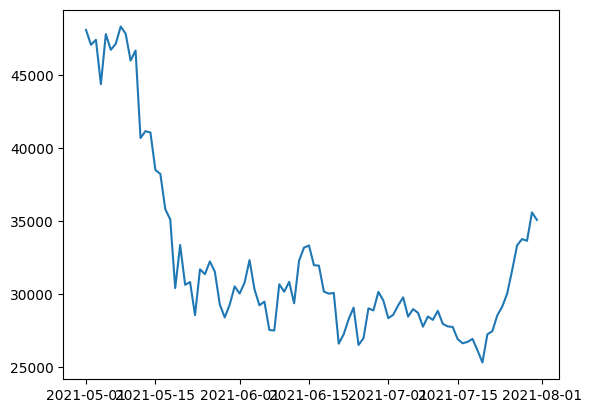

In [133]:
plt.plot(dati['Timestamp'], dati['Price'])

# Strategia

In [ ]:
def quanto_comprare(liquidità, n):
    # Acquista il 50% della liquidità posseduta
    return max(min(liquidità * 2 ** (-4 + n), liquidità), 0)

def quanto_vendere(bitcoin_posseduti):
    # Vendi il 100% dei bitcoin posseduti
    return bitcoin_posseduti

def trading_algoritmo(dati, liquidità_iniziale, bitcoin_iniziali, perc_primo_acquisto):
    # Inizializza variabili
    liquidità = liquidità_iniziale
    bitcoin_posseduti = bitcoin_iniziali
    prezzo_medio_pesato = 0
    totale_liquidità_usata = 0
    prezzo_minimo_acquisto = float('inf')
    ultima_azione = None
    transazioni = []
    n = 0
    
    for index, row in dati.iterrows():
        timestamp = row['Timestamp']
        prezzo = row['Price']
        
        # Scenario iniziale: Giorno 0 o nuovo primo acquisto
        if (ultima_azione is None or ultima_azione == 'Vendita') and liquidità > 0:
            spesa = liquidità * perc_primo_acquisto
            if spesa > 0:
                n += 1
                bitcoin_acquistati = spesa / prezzo
                liquidità -= spesa
                prezzo_medio_pesato = prezzo
                totale_liquidità_usata = spesa
                prezzo_minimo_acquisto = prezzo
                ultima_azione = 'Acquisto'
                transazioni.append([
                    timestamp, prezzo, 'Acquisto', ultima_azione, prezzo_minimo_acquisto, prezzo_medio_pesato, spesa, bitcoin_acquistati, 
                    liquidità, bitcoin_posseduti + bitcoin_acquistati, liquidità + (bitcoin_posseduti + bitcoin_acquistati) * prezzo
                ])
                bitcoin_posseduti += bitcoin_acquistati
            else:
                transazioni.append([
                    timestamp, prezzo, '-', ultima_azione, prezzo_minimo_acquisto, prezzo_medio_pesato, 0, 0,
                    liquidità, bitcoin_posseduti, liquidità + bitcoin_posseduti * prezzo
                ])
            continue
        
        # Scenario 1: Prezzo sotto il minimo
        if prezzo < prezzo_minimo_acquisto and liquidità > 0:
            spesa = quanto_comprare(liquidità, n)
            if spesa > 0:
                bitcoin_venduti = 0
                n += 1
                bitcoin_acquistati = spesa / prezzo
                bitcoin_posseduti += bitcoin_acquistati
                liquidità -= spesa
                totale_liquidità_usata += spesa
                prezzo_medio_pesato = (
                    (prezzo_medio_pesato * (totale_liquidità_usata - spesa) + prezzo * spesa) / totale_liquidità_usata
                )
                prezzo_minimo_acquisto = min(prezzo_minimo_acquisto, prezzo)
                ultima_azione = 'Acquisto'
            else:
                bitcoin_acquistati = 0
                bitcoin_venduti = 0

        # Scenario 3: Prezzo sopra la media pesata
        elif prezzo > prezzo_medio_pesato and bitcoin_posseduti > 0:
            bitcoin_venduti = quanto_vendere(bitcoin_posseduti)
            if bitcoin_venduti > 0:
                spesa = 0
                bitcoin_acquistati = 0
                n = 0
                guadagno = bitcoin_venduti * prezzo
                liquidità += guadagno
                bitcoin_posseduti -= bitcoin_venduti
                ultima_azione = 'Vendita'
                prezzo_minimo_acquisto = float('inf')
            else:
                bitcoin_venduti = 0
                bitcoin_acquistati = 0
                spesa = 0
        else:
            # Scenario 2: prezzo tra attuale minimo e attuale media pesata (estremi inclusi)
            transazioni.append([
                timestamp, prezzo, '-', ultima_azione, prezzo_minimo_acquisto, prezzo_medio_pesato, 0, 0, 
                liquidità, bitcoin_posseduti, liquidità + bitcoin_posseduti * prezzo
            ])
            # spesa = 0
            # bitcoin_venduti = 0
            # bitcoin_acquistati = 0
            continue

        # Registra la transazione
        transazioni.append([
            timestamp, prezzo, 
            'Acquisto' if spesa > 0 else 'Vendita' if bitcoin_venduti > 0 else '-', 
            ultima_azione, 
            prezzo_minimo_acquisto, 
            prezzo_medio_pesato, 
            spesa if spesa > 0 else -guadagno if bitcoin_venduti > 0 else 0, 
            bitcoin_acquistati if spesa > 0 else -bitcoin_venduti if bitcoin_venduti > 0 else 0, 
            liquidità, 
            bitcoin_posseduti, 
            liquidità + bitcoin_posseduti * prezzo
        ])
    
    # Ritorna un dataframe delle transazioni
    return pd.DataFrame(transazioni, columns=[
        'timestamp', 'prezzo', 'azione', 'ultima_azione', 'prezzo_minimo_acquisto', 'prezzo_medio_pesato', 
        'liquidità_spesa_o_guadagnata', 'bitcoin_comprati_o_venduti', 
        'liquidità_posseduta', 'bitcoin_posseduti', 'valore_totale_portafoglio'
    ])

In [135]:
df_transazioni = trading_algoritmo(dati, liquidità_iniziale=1000, bitcoin_iniziali=0, perc_primo_acquisto=0.1)
df_transazioni

2021-05-02 00:00:00 112.5
2021-05-04 00:00:00 196.875
2021-05-09 00:00:00 114.44572195384161
2021-05-10 00:00:00 200.28001341922283
2021-05-12 00:00:00 300.42002012883427
2021-05-15 00:00:00 300.42002012883427


,timestamp,prezzo,azione,ultima_azione,prezzo_minimo,prezzo_medio_pesato,liquidità_spesa_o_guadagnata,bitcoin_comprati_o_venduti,liquidità_posseduta,bitcoin_posseduti,valore_totale_portafoglio
0,2021-05-01,48110.046875,Acquisto,Acquisto,4.811005e+04,48110.046875,100.000000,0.002079,900.000000,0.002079,1000.000000
1,2021-05-02,47088.570312,Acquisto,Acquisto,4.708857e+04,47569.265165,112.500000,0.002389,787.500000,0.004468,997.876792
2,2021-05-03,47432.769531,-,Acquisto,4.708857e+04,47569.265165,0.000000,0.000000,787.500000,0.004468,999.414564
3,2021-05-04,44387.261719,Acquisto,Acquisto,4.438726e+04,46038.988699,196.875000,0.004435,590.625000,0.008903,985.808202
4,2021-05-05,47823.058594,Vendita,Vendita,inf,46038.988699,-425.772365,-0.008903,1016.397365,0.000000,1016.397365
...,...,...,...,...,...,...,...,...,...,...,...
87,2021-07-27,33336.066406,-,Acquisto,3.849874e+04,42662.646436,0.000000,0.000000,0.000000,0.024035,801.218701
88,2021-07-28,33764.222656,-,Acquisto,3.849874e+04,42662.646436,0.000000,0.000000,0.000000,0.024035,811.509261
89,2021-07-29,33643.082031,-,Acquisto,3.849874e+04,42662.646436,0.000000,0.000000,0.000000,0.024035,808.597696
90,2021-07-30,35590.078125,-,Acquisto,3.849874e+04,42662.646436,0.000000,0.000000,0.000000,0.024035,855.392949


In [136]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(0.8430678046767849)

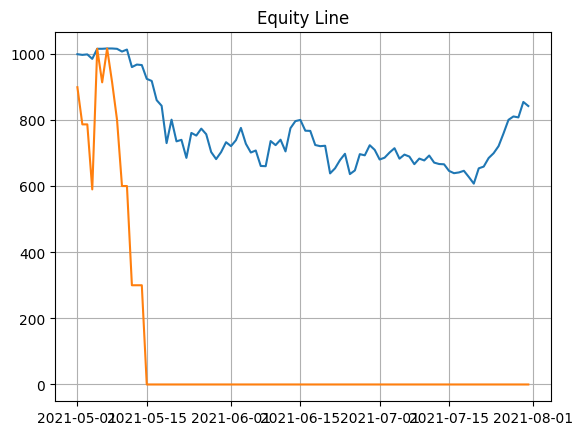

In [137]:
plt.title('Equity Line')
plt.grid()
plt.plot(df_transazioni['timestamp'], df_transazioni['valore_totale_portafoglio'])
plt.plot(df_transazioni['timestamp'], df_transazioni['liquidità_posseduta'])

In [138]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
    acquisti = df_transazioni[df_transazioni['azione'] == 'Acquisto']

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per formattare in modo sicuro i valori
    def safe_format(value, precision=2):
        return f"{float(value):.{precision}f}" if pd.notna(value) else "None"

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=[
            f"Timestamp: {timestamp}<br>Prezzo: {safe_format(prezzo)} €<br>Bitcoin venduti: {safe_format(btc_venduti, 4)}<br>Liquidità guadagnata: {safe_format(liquid_guad, 2)} €<br>Valore totale portafoglio: {safe_format(val_port, 2)} €"
            for timestamp, prezzo, btc_venduti, liquid_guad, val_port in zip(
                vendite['timestamp'],
                vendite['prezzo'],
                vendite['bitcoin_comprati_o_venduti'],
                vendite['liquidità_spesa_o_guadagnata'],
                vendite['valore_totale_portafoglio']
            )
        ],
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=[
            f"Timestamp: {timestamp}<br>Prezzo: {safe_format(prezzo)} €<br>Liquidità spesa: {safe_format(liquid_spesa, 2)} €<br>Bitcoin comprati: {safe_format(btc_comprati, 4)}<br>Valore totale portafoglio: {safe_format(val_port, 2)} €"
            for timestamp, prezzo, liquid_spesa, btc_comprati, val_port in zip(
                acquisti['timestamp'],
                acquisti['prezzo'],
                acquisti['liquidità_spesa_o_guadagnata'],
                acquisti['bitcoin_comprati_o_venduti'],
                acquisti['valore_totale_portafoglio']
            )
        ],
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [139]:
crea_grafico_transazioni(df_transazioni)